In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import ndcg_score

import pickle


In [3]:
from preprocess import Data_for_transformer_cnn_train, preprocess_data,Data_for_transformer_cnn_test
from Encoder_model import make_Encoder_model
from train_test_utils import  plot_results, train_eval
from loss_mask_utils import create_mask

In [4]:
file_path_train = r'/home/aletovv/Learning-To-Rank/other models and so on/datas_full_10k_1.pkl'
file_path_test = r'/home/aletovv/Learning-To-Rank/other models and so on/datas_full_10k_1.pkl'

train_data = preprocess_data(file_path_train,num_docs=850, which=0, is_shuffle=True, for_cnn=False)
val_data = preprocess_data(file_path_test, num_docs=850, which=-1, is_shuffle=True, for_cnn=False)

preprocess is done
preprocess is done


In [5]:
batch_size_train = 128
batch_size_test = 128

train_dataset = Data_for_transformer_cnn_test(train_data)
val_dataset = Data_for_transformer_cnn_test(val_data)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=True)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x, sublayer_output):
        return self.layer_norm(x + self.dropout(sublayer_output))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, ffn_hidden, dropout_rate):
        super().__init__()
        self.multihead_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads)
        self.attention_residual = ResidualBlock(d_model, dropout_rate)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.ReLU(),
            nn.Linear(ffn_hidden, d_model)
        )
        self.ffn_residual = ResidualBlock(d_model, dropout_rate)
        
    def forward(self, x, attention_mask=None, padding_mask=None):
        # Multi-head attention
        attn_output, _ = self.multihead_attention(
            query=x, key=x, value=x, attn_mask=attention_mask, key_padding_mask=padding_mask
        )
        x = self.attention_residual(x, attn_output)

        # Feed-forward
        ffn_output = self.feed_forward(x)
        x = self.ffn_residual(x, ffn_output)
        return x
# наш слон    
class Encoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, ffn_hidden, input_dim, dropout_rate):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model, bias=True)
        
        # Transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, ffn_hidden, dropout_rate)
            for _ in range(n_layers)
        ])
        
        # Output layer
        self.output_layer = nn.Linear(d_model, 5)

    def create_padding_matrix(self, input_tensor):
        batch_size, seq_length, _ = input_tensor.size()
        row_sums = input_tensor.sum(dim=-1).to(input_tensor.device)
        padding_mask = (row_sums != 0).float().to(input_tensor.device)
        return padding_mask

    def forward(self, x):
        # Input projection
        padding_mask = self.create_padding_matrix(x)
        
        
        x = self.input_projection(x)
                                                                                                                                                    
        # Create masks
        

        # Permute for compatibility with nn.MultiheadAttention
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        
        # Pass through Transformer layers
        for layer in self.layers:
            x = layer(x, padding_mask=padding_mask)
        
        # Compute scores for each item
        output = self.output_layer(x)  # (seq_len, batch_size, 1)                                                                                            
        return output.permute(1, 0, 2)  # (batch_size, seq_len, 1)

def make_Encoder_model(d_model = 512, n_heads = 4, n_layers = 2, ffn_hidden = 512, input_dim = 136, dropout_rate = 0.3, device = 'cuda'):

    
    return Encoder(d_model=d_model, 
                n_heads=n_heads, 
                n_layers=n_layers, 
                ffn_hidden=ffn_hidden, 
                input_dim=input_dim, 
                dropout_rate = dropout_rate
                ).to(device)



In [7]:
def train_eval(train_loader, val_loader, model, optimizer, scheduler = None, is_scheduler = False, loss_fn = None, num_epochs = 100, create_mask = create_mask, plot = True, save = True, name = 'encoder_model.pth'):
    
    ndcg_5, ndcg_10, ndcg_all = [], [], []
    losses = []
    best = 0
    for epoch in range(num_epochs):
        
        model.train()  
        total_loss_epoch = 0
        
        #train model
        for batch in train_loader:
            inputs, targets = batch 

            #forward pass
            inputs = inputs.float()
            mask = create_mask(inputs)
            
            outputs = model(inputs)
            targets = targets.float()
            
            loss = loss_fn(outputs, targets, mask)
            
            #backward pass
            optimizer.zero_grad()  
            loss.backward()        
            optimizer.step()      
            
            total_loss_epoch += loss.item()
        
        avg_loss_epoch = total_loss_epoch / len(train_loader)
        
        model.eval()
        val_loss_epoch = 0
        ndcg_scores = {5 : [],
                       10 : [],
                       'full' : []}

        #test model
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch  
                inputs = inputs.float()
                targets = targets.float()
                
                outputs = model(inputs)
                outputs = outputs.softmax(dim = -1) * torch.arange(5, device = 'cuda')
                outputs = torch.sum(outputs, dim = -1)
                # outputs = torch.argmax(outputs, dim = -1)

                #use to not add scores when all features equal to 0
                mask = inputs.sum(dim=2) != 0  

                # valid_outputs = outputs[mask] 
                # valid_targets = targets[mask] 
                
                # loss = torch.tensor(0) #loss_fn(valid_outputs, valid_targets)
                
                val_loss_epoch += loss.item()

                for i in range(inputs.size(0)):  
                    query_mask = mask[i]  
                    query_outputs = outputs[i][query_mask].squeeze()
                    query_targets = targets[i][query_mask]

                    if query_targets.numel() > 1:
                        
                        for i,k in enumerate(ndcg_scores.keys()):
                            c = None if k == 'full' else k
                            if query_targets.sum() != 0:
                                ndcg = ndcg_score(
                                    [query_targets.cpu().numpy()],
                                    [query_outputs.cpu().numpy()],
                                k = c)
                            else :
                                ndcg = 1
                            ndcg_scores[k].append(ndcg)
                        

            avg_val_loss = val_loss_epoch / len(val_loader)
            
            avg_ndcg_epoch = sum(ndcg_scores['full']) / len(ndcg_scores['full']) if ndcg_scores['full'] else 0.0
            avg_ndcg5_epoch = sum(ndcg_scores[5]) / len(ndcg_scores[5]) if ndcg_scores[5] else 0.0
            avg_ndcg10_epoch = sum(ndcg_scores[10]) / len(ndcg_scores[10]) if ndcg_scores[10] else 0.0
            
            losses.append(avg_loss_epoch)
            ndcg_all.append(avg_ndcg_epoch)
            ndcg_5.append(avg_ndcg5_epoch)
            ndcg_10.append(avg_ndcg10_epoch)
            
            if is_scheduler:
                scheduler.step()
            
            if plot:
                if epoch >= 1 :
                    plot_results(loss = losses, metrics = {'ndcg@5' : ndcg_5,
                                                            'ndcg@10' : ndcg_10, 
                                                            'ndcg full' : ndcg_all})
                    
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss_epoch:.4f}')
                print(f'Validation Loss: {avg_val_loss:.4f} || NDCG@5 {avg_ndcg5_epoch:.4f} || NDCG@10 {avg_ndcg10_epoch:.4f} || Avg NDCG: {avg_ndcg_epoch:.4f} ')
        if epoch >= 7:
            if best <= avg_ndcg5_epoch:
                best = avg_ndcg5_epoch
                torch.save(model.state_dict(), '1st check for finetune istella.pth')
                print(f'model saved on {epoch+1} epoch with ndcg@5 {best}')   
            
    return losses, {'ndcg@5' : ndcg_5,
                    'ndcg@10' : ndcg_10, 
                    'ndcg full' : ndcg_all}


In [8]:
def cross_entropy(output, y, mask=None):
        o = output.contiguous().view(-1,5)
        y1 = y.view(-1)
        ce = nn.CrossEntropyLoss(reduction = 'none')
        loss1 = ce(o,y1.long()) * mask.view(-1)
        
        outputs = output.softmax(dim = -1) * torch.arange(5, device = 'cuda')
        outputs = torch.sum(outputs, dim = -1)
        if mask is not None:
            # Set logits for padded documents to -inf
            outputs = outputs.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(outputs, dim=-1)
        n = 2.3
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y**n / (torch.sum(y**n, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return loss1.mean() + 0.01*batch_loss

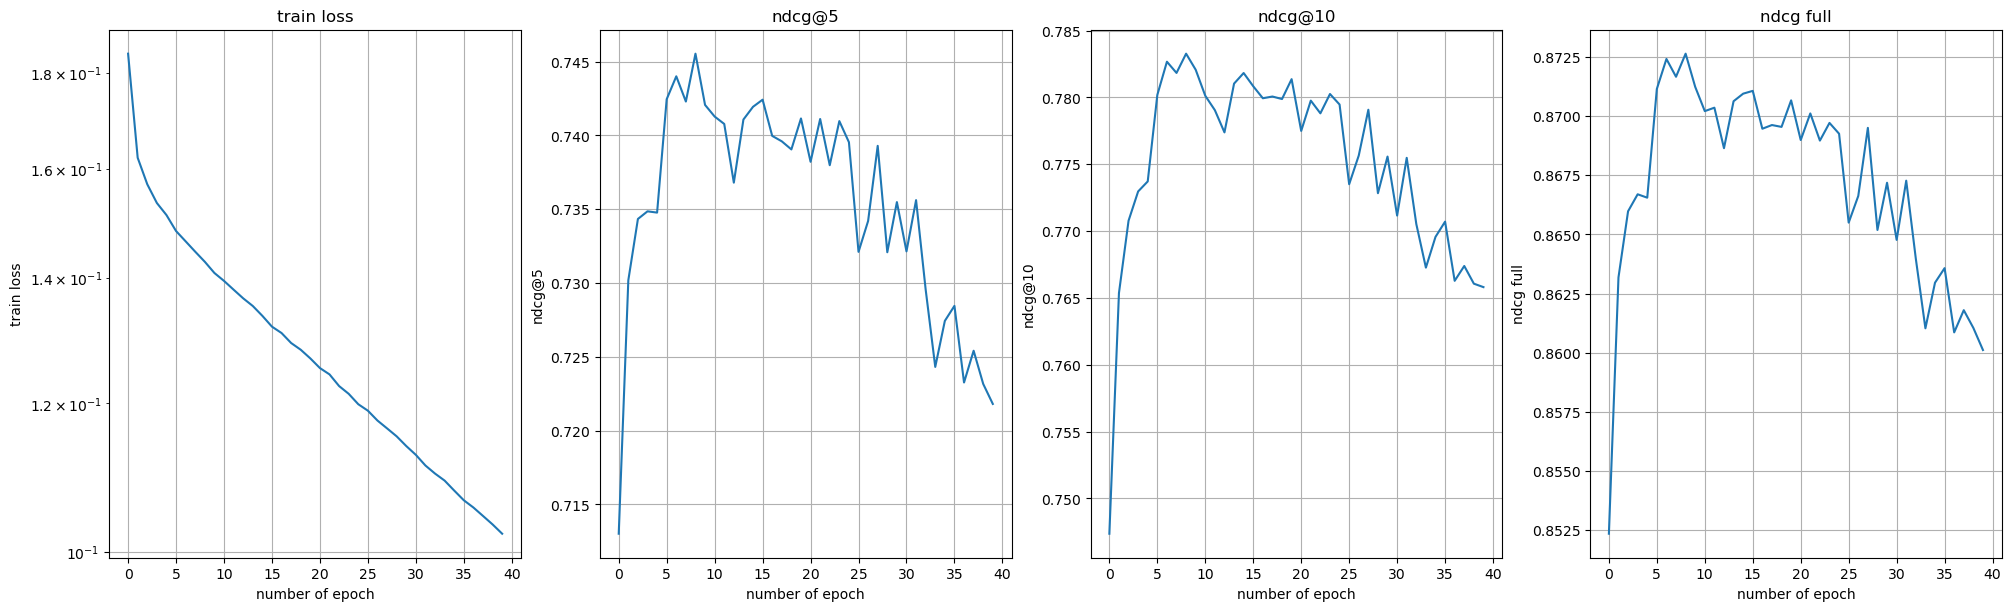

Epoch [40/40], Loss: 0.1023
Validation Loss: 0.1079 || NDCG@5 0.7218 || NDCG@10 0.7658 || Avg NDCG: 0.8601 


In [9]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 220,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 40, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('p istella', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [8]:
def cross_entropy_1(output, y, mask=None):
        o = output.contiguous().view(-1,5)
        y1 = y.view(-1)
        ce = nn.CrossEntropyLoss(reduction = 'none')
        loss1 = ce(o,y1.long()) * mask.view(-1)
        
        outputs = output.softmax(dim = -1) * torch.arange(5, device = 'cuda')
        outputs = torch.sum(outputs, dim = -1)
        if mask is not None:
            # Set logits for padded documents to -inf
            outputs = outputs.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(outputs, dim=-1)
        n = 2.3
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y**n / (torch.sum(y**n, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return loss1.mean() + 0.01 * batch_loss

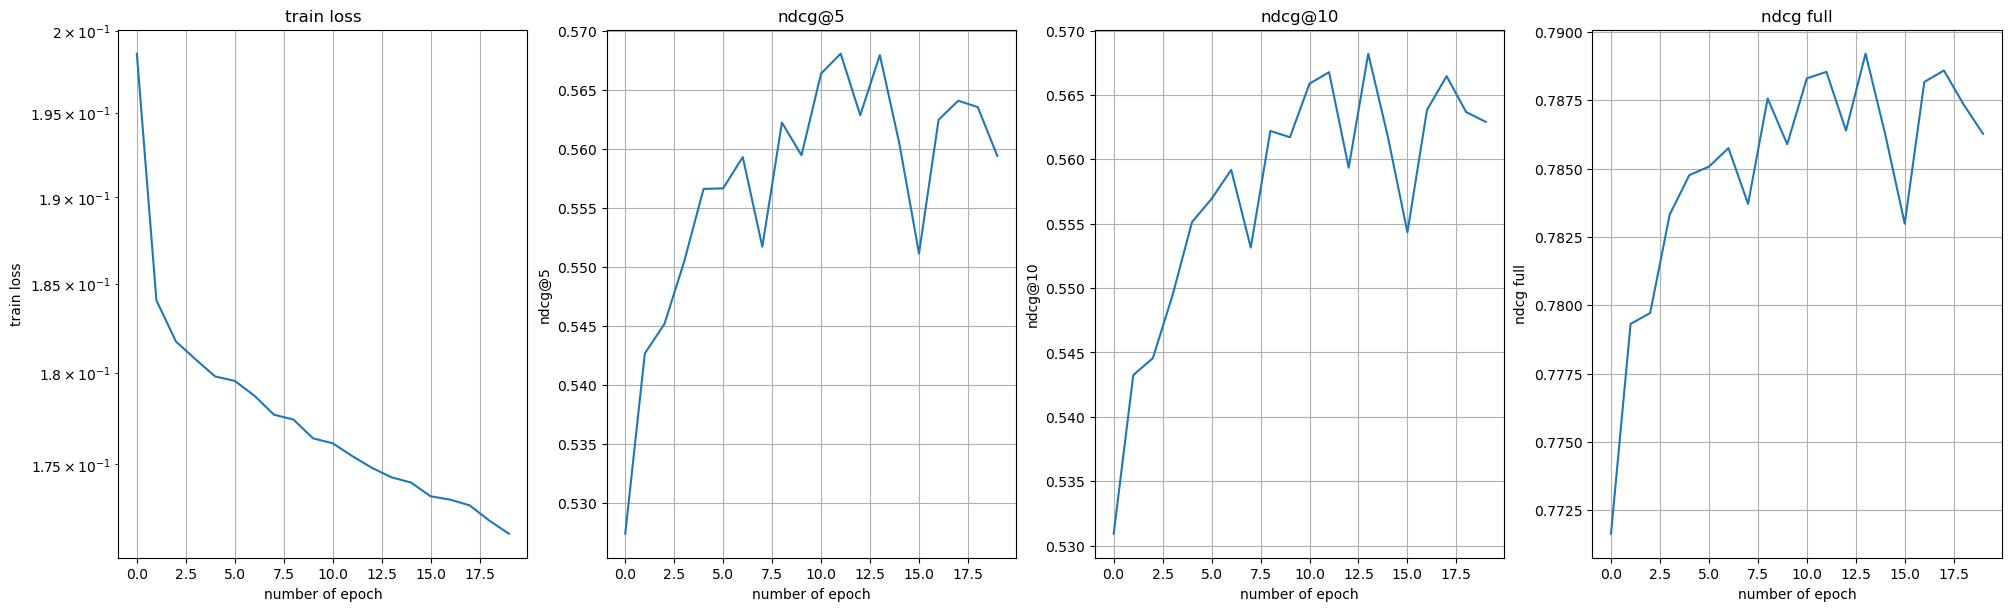

Epoch [20/40], Loss: 0.1713
Validation Loss: 0.1648 || NDCG@5 0.5594 || NDCG@10 0.5629 || Avg NDCG: 0.7863 


KeyboardInterrupt: 

In [9]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_1,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 40, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('p+l istella', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x, sublayer_output):
        return self.layer_norm(x + self.dropout(sublayer_output))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, ffn_hidden, dropout_rate):
        super().__init__()
        self.multihead_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads)
        self.attention_residual = ResidualBlock(d_model, dropout_rate)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ffn_hidden),
            nn.ReLU(),
            nn.Linear(ffn_hidden, d_model)
        )
        self.ffn_residual = ResidualBlock(d_model, dropout_rate)
        
    def forward(self, x, attention_mask=None, padding_mask=None):
        # Multi-head attention
        attn_output, _ = self.multihead_attention(
            query=x, key=x, value=x, attn_mask=attention_mask, key_padding_mask=padding_mask
        )
        x = self.attention_residual(x, attn_output)

        # Feed-forward
        ffn_output = self.feed_forward(x)
        x = self.ffn_residual(x, ffn_output)
        return x
# наш слон    
class Encoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, ffn_hidden, input_dim, dropout_rate):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model, bias=True)
        
        # Transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, ffn_hidden, dropout_rate)
            for _ in range(n_layers)
        ])
        
        # Output layer
        self.output_layer = nn.Linear(d_model, 1)

    def create_padding_matrix(self, input_tensor):
        batch_size, seq_length, _ = input_tensor.size()
        row_sums = input_tensor.sum(dim=-1).to(input_tensor.device)
        padding_mask = (row_sums != 0).float().to(input_tensor.device)
        return padding_mask

    def forward(self, x):
        # Input projection
        padding_mask = self.create_padding_matrix(x)
        
        
        x = self.input_projection(x)
                                                                                                                                                    
        # Create masks
        

        # Permute for compatibility with nn.MultiheadAttention
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        
        # Pass through Transformer layers
        for layer in self.layers:
            x = layer(x, padding_mask=padding_mask)
        
        # Compute scores for each item
        output = self.output_layer(x)  # (seq_len, batch_size, 1)                                                                                            
        return output.permute(1, 0, 2)  # (batch_size, seq_len, 1)

def make_Encoder_model(d_model = 512, n_heads = 4, n_layers = 2, ffn_hidden = 512, input_dim = 136, dropout_rate = 0.3, device = 'cuda'):

    
    return Encoder(d_model=d_model, 
                n_heads=n_heads, 
                n_layers=n_layers, 
                ffn_hidden=ffn_hidden, 
                input_dim=input_dim, 
                dropout_rate = dropout_rate
                ).to(device)



In [7]:
def train_eval(train_loader, val_loader, model, optimizer, scheduler = None, is_scheduler = False, loss_fn = None, num_epochs = 100, create_mask = create_mask, plot = True, save = True, name = 'encoder_model.pth'):
    
    ndcg_5, ndcg_10, ndcg_all = [], [], []
    losses = []
    
    for epoch in range(num_epochs):
        
        model.train()  
        total_loss_epoch = 0
        
        #train model
        for batch in train_loader:
            inputs, targets = batch 

            #forward pass
            inputs = inputs.float()
            mask = create_mask(inputs)
            
            outputs = model(inputs)
            targets = targets.float()
            
            loss = loss_fn(outputs, targets, mask)
            
            #backward pass
            optimizer.zero_grad()  
            loss.backward()        
            optimizer.step()      
            
            total_loss_epoch += loss.item()
        
        avg_loss_epoch = total_loss_epoch / len(train_loader)
        
        model.eval()
        val_loss_epoch = 0
        ndcg_scores = {5 : [],
                       10 : [],
                       'full' : []}

        #test model
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch  
                inputs = inputs.float()
                targets = targets.float()
                
                outputs = model(inputs)
                # outputs = outputs.softmax(dim = -1) * torch.arange(5, device = 'cuda')
                # outputs = torch.sum(outputs, dim = -1)
                # outputs = torch.argmax(outputs, dim = -1)

                #use to not add scores when all features equal to 0
                mask = inputs.sum(dim=2) != 0  

                # valid_outputs = outputs[mask] 
                # valid_targets = targets[mask] 
                
                # loss = torch.tensor(0) #loss_fn(valid_outputs, valid_targets)
                
                val_loss_epoch += loss.item()

                for i in range(inputs.size(0)):  
                    query_mask = mask[i]  
                    query_outputs = outputs[i][query_mask].squeeze()
                    query_targets = targets[i][query_mask]

                    if query_targets.numel() > 1:
                        
                        for i,k in enumerate(ndcg_scores.keys()):
                            c = None if k == 'full' else k
                            if query_targets.sum() != 0:
                                ndcg = ndcg_score(
                                    [query_targets.cpu().numpy()],
                                    [query_outputs.cpu().numpy()],
                                k = c)
                            else :
                                ndcg = 1
                            ndcg_scores[k].append(ndcg)
                        

            avg_val_loss = val_loss_epoch / len(val_loader)
            
            avg_ndcg_epoch = sum(ndcg_scores['full']) / len(ndcg_scores['full']) if ndcg_scores['full'] else 0.0
            avg_ndcg5_epoch = sum(ndcg_scores[5]) / len(ndcg_scores[5]) if ndcg_scores[5] else 0.0
            avg_ndcg10_epoch = sum(ndcg_scores[10]) / len(ndcg_scores[10]) if ndcg_scores[10] else 0.0
            
            losses.append(avg_loss_epoch)
            ndcg_all.append(avg_ndcg_epoch)
            ndcg_5.append(avg_ndcg5_epoch)
            ndcg_10.append(avg_ndcg10_epoch)
            
            if is_scheduler:
                scheduler.step()
            
            if plot:
                if epoch >= 1 :
                    plot_results(loss = losses, metrics = {'ndcg@5' : ndcg_5,
                                                            'ndcg@10' : ndcg_10, 
                                                            'ndcg full' : ndcg_all})
                    
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss_epoch:.4f}')
                print(f'Validation Loss: {avg_val_loss:.4f} || NDCG@5 {avg_ndcg5_epoch:.4f} || NDCG@10 {avg_ndcg10_epoch:.4f} || Avg NDCG: {avg_ndcg_epoch:.4f} ')
    if save:
        torch.save(model.state_dict(), name)
                
            
    return losses, {'ndcg@5' : ndcg_5,
                    'ndcg@10' : ndcg_10, 
                    'ndcg full' : ndcg_all}


In [8]:
def cross_entropy_2(output, y, mask=None):
        """
        Compute cross-entropy loss for each document, ignoring padded documents.
    
        Args:
        - output (Tensor): Model's predicted output logits, shape [batch_size, num_docs, num_classes].
        - y (Tensor): True target labels, shape [batch_size, num_docs].
        - mask (Tensor, optional): A boolean mask indicating valid documents (True for valid, False for padded), 
                                   shape [batch_size, num_docs].
    
        Returns:
        - batch_loss (Tensor): Mean loss over the batch, ignoring padded documents if mask is provided.
        """
        output = output.squeeze(-1)  # output: [batch_size, num_docs]
    
        if mask is not None:
            # Set logits for padded documents to -inf
            output = output.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(output, dim=-1)
        n = 2
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y**n / (torch.sum(y**n, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return batch_loss

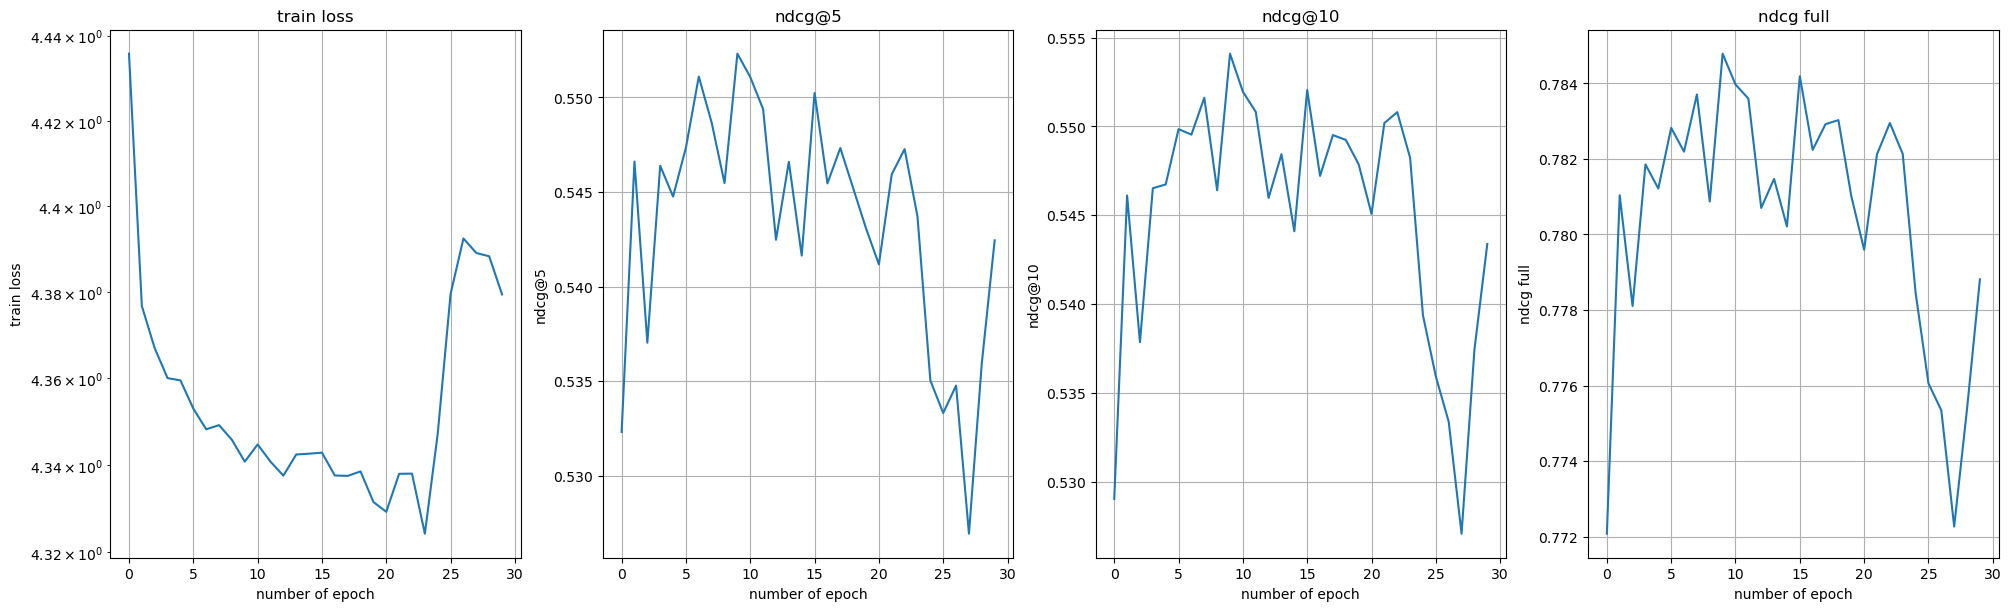

Epoch [30/30], Loss: 4.3795
Validation Loss: 4.3516 || NDCG@5 0.5424 || NDCG@10 0.5434 || Avg NDCG: 0.7788 


In [10]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_2,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 2 listnet web10k', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

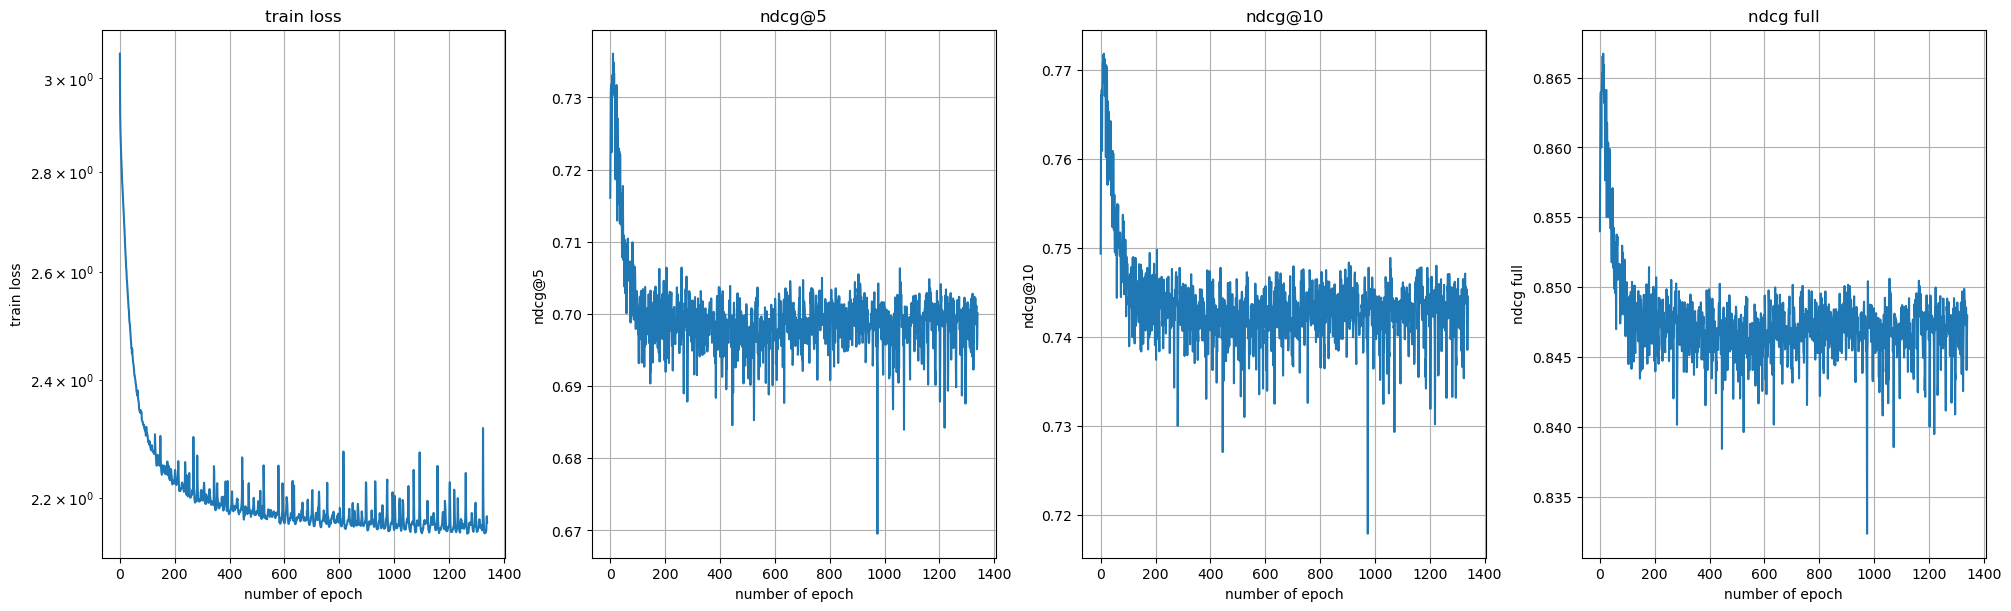

Epoch [1340/3000], Loss: 2.1595
Validation Loss: 2.2238 || NDCG@5 0.7001 || NDCG@10 0.7445 || Avg NDCG: 0.8480 


KeyboardInterrupt: 

In [16]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_2,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 220,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 3000, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 2.3 listnet istella', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_3,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 4 listnet', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
def cross_entropy_4(output, y, mask=None):
        """
        Compute cross-entropy loss for each document, ignoring padded documents.
    
        Args:
        - output (Tensor): Model's predicted output logits, shape [batch_size, num_docs, num_classes].
        - y (Tensor): True target labels, shape [batch_size, num_docs].
        - mask (Tensor, optional): A boolean mask indicating valid documents (True for valid, False for padded), 
                                   shape [batch_size, num_docs].
    
        Returns:
        - batch_loss (Tensor): Mean loss over the batch, ignoring padded documents if mask is provided.
        """
        output = output.squeeze(-1)  # output: [batch_size, num_docs]
    
        if mask is not None:
            # Set logits for padded documents to -inf
            output = output.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(output, dim=-1)
        n = 5
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y**n / (torch.sum(y**n, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return batch_loss

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_4,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 5 listnet', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
def cross_entropy_5(output, y, mask=None):
        """
        Compute cross-entropy loss for each document, ignoring padded documents.
    
        Args:
        - output (Tensor): Model's predicted output logits, shape [batch_size, num_docs, num_classes].
        - y (Tensor): True target labels, shape [batch_size, num_docs].
        - mask (Tensor, optional): A boolean mask indicating valid documents (True for valid, False for padded), 
                                   shape [batch_size, num_docs].
    
        Returns:
        - batch_loss (Tensor): Mean loss over the batch, ignoring padded documents if mask is provided.
        """
        output = output.squeeze(-1)  # output: [batch_size, num_docs]
    
        if mask is not None:
            # Set logits for padded documents to -inf
            output = output.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(output, dim=-1)
        n = 1.5
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y**n / (torch.sum(y**n, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return batch_loss

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_5,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 1.5 listnet', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
def cross_entropy_6(output, y, mask=None):
        """
        Compute cross-entropy loss for each document, ignoring padded documents.
    
        Args:
        - output (Tensor): Model's predicted output logits, shape [batch_size, num_docs, num_classes].
        - y (Tensor): True target labels, shape [batch_size, num_docs].
        - mask (Tensor, optional): A boolean mask indicating valid documents (True for valid, False for padded), 
                                   shape [batch_size, num_docs].
    
        Returns:
        - batch_loss (Tensor): Mean loss over the batch, ignoring padded documents if mask is provided.
        """
        output = output.squeeze(-1)  # output: [batch_size, num_docs]
    
        if mask is not None:
            # Set logits for padded documents to -inf
            output = output.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(output, dim=-1)
        n = 2.3
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y**n / (torch.sum(y**n, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return batch_loss

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_6,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 2.3 listnet', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
def cross_entropy_7(output, y, mask=None):
        """
        Compute cross-entropy loss for each document, ignoring padded documents.
    
        Args:
        - output (Tensor): Model's predicted output logits, shape [batch_size, num_docs, num_classes].
        - y (Tensor): True target labels, shape [batch_size, num_docs].
        - mask (Tensor, optional): A boolean mask indicating valid documents (True for valid, False for padded), 
                                   shape [batch_size, num_docs].
    
        Returns:
        - batch_loss (Tensor): Mean loss over the batch, ignoring padded documents if mask is provided.
        """
        output = output.squeeze(-1)  # output: [batch_size, num_docs]
    
        if mask is not None:
            # Set logits for padded documents to -inf
            output = output.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(output, dim=-1)
        n = 2
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y**n / (torch.sum(y**n, dim=-1, keepdim=True) + 1e-10) * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return batch_loss

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_7,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 4,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.45,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 2 listnet 4 2 0.45', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_7,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 4,
                'n_layers' : 4,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.3,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 2 listnet 4 4 0.3', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_7,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.08,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('deg = 2 listnet 2 2 0.08', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    

In [ ]:
def cross_entropy_8(output, y, mask=None):
        """
        Compute cross-entropy loss for each document, ignoring padded documents.
    
        Args:
        - output (Tensor): Model's predicted output logits, shape [batch_size, num_docs, num_classes].
        - y (Tensor): True target labels, shape [batch_size, num_docs].
        - mask (Tensor, optional): A boolean mask indicating valid documents (True for valid, False for padded), 
                                   shape [batch_size, num_docs].
    
        Returns:
        - batch_loss (Tensor): Mean loss over the batch, ignoring padded documents if mask is provided.
        """
        output = output.squeeze(-1)  # output: [batch_size, num_docs]
    
        if mask is not None:
            # Set logits for padded documents to -inf
            output = output.masked_fill(~mask, -1e9)
    
        # Compute log-softmax over the class dimension
        log_softmax_output = torch.log_softmax(output, dim=-1)
        y_softmax = torch.softmax(y.float(), dim = -1)
        n = 2
        # Calculate the per-document cross-entropy loss
        loss = -torch.sum(y_softmax * log_softmax_output, dim=-1)  # Summed loss over classes
        # Final batch loss
        batch_loss = torch.mean(loss)  # Mean over all batch elements
    
        return batch_loss

In [ ]:
import pickle

def new_model1(train_loader = train_loader, val_loader = val_loader, loss_fn = cross_entropy_8,mask = create_mask):
    model_params = {'d_model' : 512,
                'n_heads' : 2,
                'n_layers' : 2,
                'ffn_hidden' : 512,
                'input_dim' : 136,
                'dropout_rate' : 0.15,
                'device' : 'cuda'
                }
    
    initial_lr = 1e-3

    model = make_Encoder_model(**model_params)

    optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
    
    train_params = {'train_loader' : train_loader,
                'val_loader' : val_loader,
                'model' : model,
                'optimizer' : optimizer,
                'loss_fn' : loss_fn,  
                'num_epochs' : 30, 
                'create_mask' : mask,
                }
    for batch in train_loader:
        print(batch[0].size())
        break
    return train_params, model, optimizer

losses, metrics = {}, {}
for i in range(5):
    train_params, _, __ = new_model1()
    print(_,__)
    loss, mettrics = train_eval(**train_params)
    losses[i] = loss
    metrics[i] = mettrics
    
with open('softmax listnet', 'wb') as f:
    pickle.dump(file=f, obj=[losses, metrics])
    